In [1]:
import re
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Embedding, Dropout
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

2023-02-04 23:13:27.953448: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-04 23:13:32.364959: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-04 23:13:32.365029: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-04 23:13:43.440527: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

## Data Preprocessing

In [28]:
# read dataset

dt = pd.read_csv('data_train.csv')
dt = dt.sample(frac=1)

dt

,tweet,label
693,,NaN
1489,NaN,NaN
81,andi arif juga bilang pdip menawarkan capres ...,tidak mendukung
815,jelas deh siapa yg bakal jd lawan,NaN
409,waras id coattail effect positif akan dirasak...,dukungan
...,...,...
699,NaN,NaN
455,pengumuman resmi disampaikan langsung oleh ke...,netral
327,insyaallah anies ri 1,dukungan
764,ummad islam memang benar wajib memilih pemimp...,dukungan


In [29]:
# delete NaN data
dt.dropna(inplace=True)

dt

,tweet,label
81,andi arif juga bilang pdip menawarkan capres ...,tidak mendukung
409,waras id coattail effect positif akan dirasak...,dukungan
964,kita lihat strategi apa yang bakal digunakan d...,netral
1513,ferdinandhutah nasdem mumpung blm makin hancur...,tidak mendukung
78,jadi kalau ketua dprd dengan sekda kompak ins...,netral
...,...,...
1439,nasdem jangan jadi pdip apa kata ketum diangga...,tidak mendukung
455,pengumuman resmi disampaikan langsung oleh ke...,netral
327,insyaallah anies ri 1,dukungan
764,ummad islam memang benar wajib memilih pemimp...,dukungan


In [30]:
# update label

dt['label'] = dt['label'].replace({'pujian':'dukungan', 'hujatan':'tidak mendukung'})

dt['label'].value_counts()

dukungan           569
tidak mendukung    486
netral             181
Name: label, dtype: int64

## Data Preparation

<AxesSubplot:>

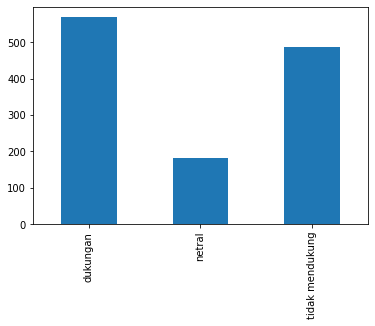

In [31]:
# visualize data

dt['label'].value_counts().sort_index().plot.bar()

In [32]:
# tokenizer text

tokenizer = Tokenizer(num_words=5000, split=" ")

tokenizer.fit_on_texts(dt['tweet'].values)
X = tokenizer.texts_to_sequences(dt['tweet'].values)
X = pad_sequences(X)
print(X)

[[   0    0    0 ... 1864 1865  835]
 [   0    0    0 ...  335  217   36]
 [   0    0    0 ...   29 1868 1124]
 ...
 [   0    0    0 ...    1   37  382]
 [   0    0    0 ... 1861 4595   31]
 [   0    0    0 ...    2 1829 4597]]


In [33]:
# get label

y = pd.get_dummies(dt['label']).values
y

array([[0, 0, 1],
       [1, 0, 0],
       [0, 1, 0],
       ...,
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0]], dtype=uint8)

In [34]:
# split dataset

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

print(X_train.shape)
print(X_test.shape)

(988, 51)
(248, 51)


## Training Model

In [35]:
# LSTM Modelling

model = Sequential()
model.add(Embedding(5000, 256))
model.add(Dropout(0.3))
model.add(LSTM(256, return_sequences=True, dropout=0.3, recurrent_dropout=0.2))
model.add(LSTM(256, dropout=0.3, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 256)         1280000   
                                                                 
 dropout_2 (Dropout)         (None, None, 256)         0         
                                                                 
 lstm_4 (LSTM)               (None, None, 256)         525312    
                                                                 
 lstm_5 (LSTM)               (None, 256)               525312    
                                                                 
 dense_2 (Dense)             (None, 3)                 771       
                                                                 
Total params: 2,331,395
Trainable params: 2,331,395
Non-trainable params: 0
_________________________________________________________________


In [36]:
# train model

batch_size = 32
epochs = 25

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=2, validation_data=(X_test, y_test))

Epoch 1/25
31/31 - 18s - loss: 1.0087 - accuracy: 0.5020 - val_loss: 0.8783 - val_accuracy: 0.5968 - 18s/epoch - 567ms/step
Epoch 2/25
31/31 - 12s - loss: 0.7905 - accuracy: 0.6842 - val_loss: 0.7859 - val_accuracy: 0.6855 - 12s/epoch - 386ms/step
Epoch 3/25
31/31 - 12s - loss: 0.4839 - accuracy: 0.8026 - val_loss: 0.8821 - val_accuracy: 0.6532 - 12s/epoch - 380ms/step
Epoch 4/25
31/31 - 13s - loss: 0.2791 - accuracy: 0.9099 - val_loss: 0.9228 - val_accuracy: 0.7016 - 13s/epoch - 427ms/step
Epoch 5/25
31/31 - 14s - loss: 0.1153 - accuracy: 0.9626 - val_loss: 1.2446 - val_accuracy: 0.6452 - 14s/epoch - 437ms/step
Epoch 6/25
31/31 - 12s - loss: 0.0934 - accuracy: 0.9757 - val_loss: 1.1576 - val_accuracy: 0.6492 - 12s/epoch - 390ms/step
Epoch 7/25
31/31 - 12s - loss: 0.0672 - accuracy: 0.9798 - val_loss: 1.0819 - val_accuracy: 0.6210 - 12s/epoch - 390ms/step
Epoch 8/25
31/31 - 14s - loss: 0.0491 - accuracy: 0.9868 - val_loss: 1.2039 - val_accuracy: 0.6613 - 14s/epoch - 442ms/step
Epoch 9/

In [37]:
# save model into file .h5

model.save('sentiment_analysis.h5')

AttributeError: 'History' object has no attribute 'save'

In [38]:
import seaborn as sns
import string

In [39]:
# Mengambil data dari history pelatihan model
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

In [40]:
# Membuat plot
plt.figure(figsize=(12,5))
sns.set_style("whitegrid")

<Figure size 864x360 with 0 Axes>

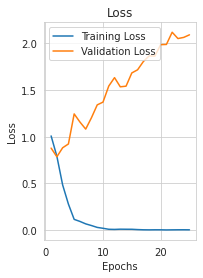

In [41]:
plt.subplot(1,2,1)
sns.lineplot(x=range(1,epochs+1), y=train_loss, label='Training Loss')
sns.lineplot(x=range(1,epochs+1), y=val_loss, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

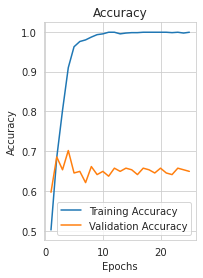

In [42]:
plt.subplot(1,2,2)
sns.lineplot(x=range(1,epochs+1), y=train_acc, label='Training Accuracy')
sns.lineplot(x=range(1,epochs+1), y=val_acc, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [44]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
print(classification_report(y_true, y_pred))

8/8 [==============================] - 1s 56ms/step
              precision    recall  f1-score   support

           0       0.71      0.74      0.72       118
           1       0.32      0.33      0.33        27
           2       0.66      0.63      0.65       103

    accuracy                           0.65       248
   macro avg       0.57      0.57      0.57       248
weighted avg       0.65      0.65      0.65       248



In [45]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_true, y_pred)
print(conf_mat)

[[87  8 23]
 [ 8  9 10]
 [27 11 65]]


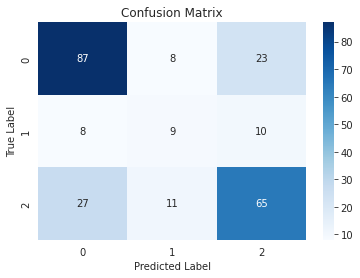

In [46]:
sns.heatmap(conf_mat, annot=True, cmap='Blues', fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## Evaluate Model

In [43]:
# evaluate model with data test

score, acc = model.evaluate(X_test, y_test, verbose = 2, batch_size = batch_size)

print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

8/8 - 0s - loss: 2.0915 - accuracy: 0.6492 - 438ms/epoch - 55ms/step
score: 2.09
acc: 0.65


## Predict New Dataset

In [1]:
# read new dataset
import re
import numpy as np
import pandas as pd
data = pd.read_csv('tweet2.csv')
# menghapus kolom id
data = data.drop(['id'], axis=1)

data

,tweet
0,"@M45Broo_ Cebong benar2 panik luar biasa, ini ..."
1,@Relawananies https://t.co/uf5sE0iGLI
2,RT @BosPurwa: #IndonesiaMemanggil \n5 Tahun An...
3,RT @aLy_Bima: Video ini hanya untuk orang yang...
4,"RT @tempodotco: ""Tidak ringan permasalahan di ..."
...,...
445,RT @Relawananies: Momen haru saat Anies Baswed...
446,@maspiyuaja Terima kasih om https://t.co/PUgr2...
447,RT @BosPurwa: #IndonesiaMemanggil \n5 Tahun An...
448,RT @OposisiCerdas: Kamhar Lakumani Sebut Anies...


In [2]:
# data preprocessing

def tweetPrepocessing(text):
  text = text.lower()
  text = re.sub('\n','', text)
  text = re.sub('rt ','', text)
  text = re.sub('#','', text)
  text = re.sub('@\w+(?:\:)\ ','', text)
  text = re.sub(r'(?:\@|http?\://|https?\://|www)\S+','', text)
  text = re.sub('[^a-zA-z0-9\s]','', text)
  text = re.sub('  ',' ', text)

  if text == ' ':
    return None

  return text

data = data.sample(frac=1)
data['tweet'] = data['tweet'].apply(tweetPrepocessing)
data.dropna(inplace=True)
data.reset_index(drop=True, inplace = True)

data

,tweet
0,warga kota makassar menyambut pelepasan gubern...
1,terimakasih pak anies baswedannct ballondor ga...
2,jika memang ini di lakukan untuk menjatuhkan p...
3,mending ma gatot sih ingat dia menantu nya he...
4,rakyat tahu mana pemimpin yg baik jujur amanah...
...,...
430,partai koalisi pemerintah 82 suaranya di parle...
431,cuma 2 perahu ngakunya ratusan
432,kenduri rakyat jarnas anies baswedan memggelar...
433,maklum aja duaduanya pecatan mau gimana lagi


In [3]:
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

tokenizer = Tokenizer(num_words=5000, split=" ")

tokenizer.fit_on_texts(data['tweet'].values)
X = tokenizer.texts_to_sequences(data['tweet'].values)
X = pad_sequences(X)
print(X)


tokenizer.fit_on_texts(data['tweet'].values)

X_new = tokenizer.texts_to_sequences(data['tweet'].values)
X_new = pad_sequences(X_new)
X_new.shape

2023-01-22 11:41:05.401851: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-22 11:41:08.637763: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-22 11:41:08.637827: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-22 11:41:19.943653: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

[[  0   0   0 ... 136  11 164]
 [  0   0   0 ... 430 165 321]
 [  0   0   0 ... 434 640  13]
 ...
 [  0   0   0 ...  20 182 183]
 [  0   0   0 ...  14 381  79]
 [  0   0   0 ...  51   7 269]]


(435, 42)

In [5]:
# load model
from keras.models import Sequential, load_model
mymodel = load_model('sentiment_analysis.h5')

2023-01-22 11:41:39.306401: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-22 11:41:39.306513: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-01-22 11:41:39.306599: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-01-22 11:41:39.306682: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcufft.so.10'; dlerror: libcufft.so.10: cannot open shared object file: No such file or directory
2023-01-22 11:41:39.306764: W tensorfl

In [6]:
# predict data

pred = mymodel.predict(X_new)

14/14 [==============================] - 2s 48ms/step


In [7]:
# labelling

def labelling(array):
  labels = ['dukungan', 'netral', 'tidak mendukung']
  output = []
  for a in array:
    output.append(labels[np.argmax(a)])
  return output

label = labelling(pred)

In [8]:
label

['netral',
 'dukungan',
 'dukungan',
 'tidak mendukung',
 'netral',
 'netral',
 'tidak mendukung',
 'netral',
 'dukungan',
 'dukungan',
 'netral',
 'netral',
 'dukungan',
 'tidak mendukung',
 'tidak mendukung',
 'dukungan',
 'netral',
 'netral',
 'dukungan',
 'dukungan',
 'netral',
 'netral',
 'dukungan',
 'tidak mendukung',
 'dukungan',
 'dukungan',
 'netral',
 'netral',
 'dukungan',
 'tidak mendukung',
 'dukungan',
 'tidak mendukung',
 'netral',
 'netral',
 'netral',
 'netral',
 'tidak mendukung',
 'dukungan',
 'netral',
 'dukungan',
 'dukungan',
 'netral',
 'dukungan',
 'netral',
 'netral',
 'netral',
 'netral',
 'netral',
 'dukungan',
 'netral',
 'netral',
 'dukungan',
 'dukungan',
 'dukungan',
 'netral',
 'tidak mendukung',
 'netral',
 'tidak mendukung',
 'dukungan',
 'netral',
 'tidak mendukung',
 'dukungan',
 'netral',
 'dukungan',
 'dukungan',
 'dukungan',
 'dukungan',
 'dukungan',
 'netral',
 'dukungan',
 'tidak mendukung',
 'tidak mendukung',
 'tidak mendukung',
 'tidak mendu

In [9]:
# add label to data

data['label'] = label

data

,tweet,label
0,warga kota makassar menyambut pelepasan gubern...,netral
1,terimakasih pak anies baswedannct ballondor ga...,dukungan
2,jika memang ini di lakukan untuk menjatuhkan p...,dukungan
3,mending ma gatot sih ingat dia menantu nya he...,tidak mendukung
4,rakyat tahu mana pemimpin yg baik jujur amanah...,netral
...,...,...
430,partai koalisi pemerintah 82 suaranya di parle...,dukungan
431,cuma 2 perahu ngakunya ratusan,tidak mendukung
432,kenduri rakyat jarnas anies baswedan memggelar...,dukungan
433,maklum aja duaduanya pecatan mau gimana lagi,dukungan


In [43]:
# save to new csv

data.to_csv('tweet2_new.csv', index=False)